In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import sklearn as skt
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import re


## Scraping newspaper articles to create a corpus using newspaper3k

In [14]:
#import newspaper
#times_paper= newspaper.build('https://www.indiatimes.com/',memoize_articles=False)
# n=150 # We are going to use 150 articles
# document=[0]*n
# for i in range(3,n+3):
#     sample=times_paper.articles[i]
#     sample.download()
#     sample.parse()
#     document[i-3]= sample.text

### Let us check a sample article scraped using the code above on April 26, 2021.

In [2]:
document=np.load('indiatimes_april26.npy')
document[5]

'In the midst of the due to rising cases of COVID, an auto driver from Ranchi is showing hope for those in a medical emergency, as per ANI.\n\nRavi Agarwal provides rides for free to the needy who have to go to hospitals at a time when due to the pandemic majority of auto drivers do not want to take passengers to the hospital.\n\nANI\n\nHe has been doing so since April 15.\n\n"There was a woman who needed to go to Rajendra Institute of Medical Sciences (RIMS). No auto driver was ready to take her there out of fear. She was ready to pay whatever money was being demanded. I offered to take her and dropped her near the trauma centre there. I don\'t know if she was a Covid patient or not, but I declined to accept the money she offered. When I was returning, I realised that many people like her are being denied transport services because of the fear of Covid," he said.\n\nANI\n\nPeople like him show that all is not lost. He is doing his bit to help those in need.\n\n'

In [12]:
#np.save('indiatimes_april26',document)


### Text preprocessing and exploratory data analysis
#### We create a data preparation function that performs the following text pre-preprocessing steps, strips tags, normalizes URLs, replaces emailids, replaces dollar numbers, lemmatizes using WordNet.

In [4]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
def prepare_data(input_text):
    """
    Inputs: input_text: string 
    Returns: clean_document : string 
    """
    
    def strip_tags(string):
        return re.sub(r'<.*?>', '', string)

    def normalize_URL(sample):
        """Remove URLs from a sample string"""
        return re.sub(r"http\S+", "httpadd", sample)
    def replace_emailid(sample):
        return re.sub(r"\S+@\S+","emailaddr",sample)
    def get_lemma(word):
        lemma = wn.morphy(word)
        if lemma is None:
            return word
        else:
            return lemma
    
    text=normalize_URL(input_text)
    text=replace_emailid(text)
    text=re.sub(r"[+$]\S+","dollarnumber",text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]
    
    en_stop = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in en_stop]
    tokens = [get_lemma(word) for word in tokens]
    tokens= [WordNetLemmatizer().lemmatize(word) for word in tokens]
    clean_doc = ''
    for i in range(len(tokens)):
        clean_doc += ' ' + tokens[i] 
    return clean_doc

In [5]:
corpus=[prepare_data(article) for article in document] # Preparing clean corpus

### Next, we visualize the most frequent words appearing in the corpus

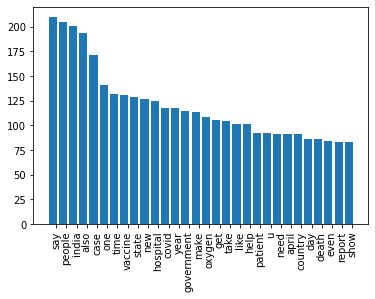

In [7]:
from collections import Counter
words_collection=' '.join(corpus).split()

counts = dict(Counter(words_collection).most_common(30))

labels, values = zip(*counts.items())

# Sorts  values in descending order
indSort = np.argsort(values)[::-1]

# Rearranges  data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes,values)
plt.xticks(indexes + bar_width, labels)
plt.xticks(rotation = 90)
plt.show()





### Creating a dictionary

In [8]:
import gensim
from gensim import corpora
corpus_tokenized=[article.split() for article in corpus]
dictionary = corpora.Dictionary(corpus_tokenized)
print(dictionary)

Dictionary(6117 unique tokens: ['accept', 'align', 'best', 'change', 'continue']...)


### Creating a BagofWords(BoW) model  

In [9]:
BoW_corpus = [dictionary.doc2bow(article.split()) for article in corpus]

### Next we create a Topic model using Latent Dirchlet Allocation, with gensim. 

In [13]:
NUM_TOPICS = 4
ldamodel = gensim.models.ldamodel.LdaModel(BoW_corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.007*"time" + 0.006*"people" + 0.005*"help" + 0.005*"one"')
(1, '0.010*"case" + 0.010*"say" + 0.009*"state" + 0.008*"government"')
(2, '0.007*"covid" + 0.006*"april" + 0.006*"oxygen" + 0.006*"say"')
(3, '0.007*"vaccine" + 0.007*"also" + 0.005*"india" + 0.005*"one"')


#### In order to get a rough idea of the optimal number of topics we compute Coherence Score for the corpus for the trained model using different number of topics. A more careful analysis should use a different validation set.

In [11]:
from gensim.models import CoherenceModel# Compute Coherence Score
list_for_plot=[]
m=10
for NUM_TOPICS in range(3,3+m):
    ldamodel = gensim.models.ldamodel.LdaModel(BoW_corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=corpus_tokenized, dictionary=dictionary, coherence='c_v')
    list_for_plot.append([NUM_TOPICS,coherence_model_lda.get_coherence()])
list_for_plot=np.asarray(list_for_plot).reshape(m,2)

Text(0, 0.5, 'Coherence Score')

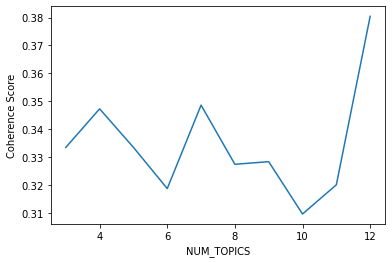

In [12]:
plt.plot(list_for_plot[:,0],list_for_plot[:,1])
plt.xlabel("NUM_TOPICS")
plt.ylabel("Coherence Score")

A choice of 4 or 7 topics seems to be fine, based on this preliminary validation analysis. 

### Visualising the topics using PyldaVis

In [15]:
from IPython.core.display import display, HTML
import pyLDAvis 
from pyLDAvis  import *
import pyLDAvis.gensim_models as gensimvis
#display(HTML("<style>.container { max-width:100% !important; }</style>"))
#display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
#display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
#display(HTML("<style>.input_area { max-width:100% !important; }</style>"))
%matplotlib inline
pyLDAvis.enable_notebook()
ldamodel = gensim.models.ldamodel.LdaModel(BoW_corpus, num_topics = 4, id2word=dictionary, passes=15)
vis = gensimvis.prepare(ldamodel, BoW_corpus, dictionary=dictionary)
pyLDAvis.display(vis)

/home/rajarshi/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Conclusion

Unsurprisingly, topics are mostly covid related. 